In [1]:
%autosave 45


Autosaving every 45 seconds


### 8. 2 TensorFlow keras
* installing TensorFlow
* loading pictures

In [2]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
import tensorflow as tf
from tensorflow import keras

2023-07-02 17:03:17.893660: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [4]:
from tensorflow.keras.preprocessing.image import load_img

In [5]:
load_img

<function keras.utils.image_utils.load_img(path, grayscale=False, color_mode='rgb', target_size=None, interpolation='nearest', keep_aspect_ratio=False)>

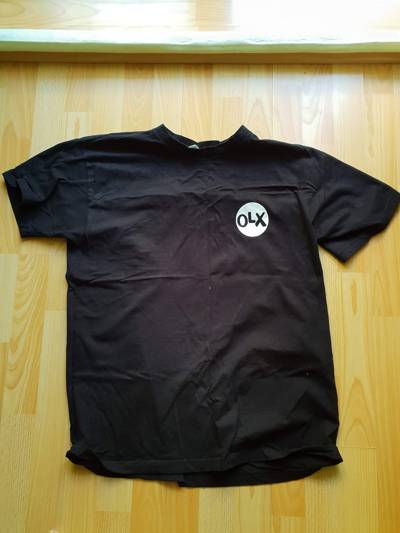

In [6]:
path = './clothing-dataset-small/train/t-shirt'
name = '5f0a3fa0-6a3d-4b68-b213-72766a643de7.jpg'
fullname = path + '/' + name
load_img(fullname)

### 8. 3 Pre-trained convolutional neural networks
* imagenet dataset: https://www.image-net.org/
* Pre-trained models: https://keras.io/api/applications/


In [7]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input 
from tensorflow.keras.applications.xception import decode_predictions

In [8]:
model = Xception(weights='imagenet', input_shape=(299, 299, 3))

2023-07-02 17:03:19.910272: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-02 17:03:19.917330: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-02 17:03:19.917942: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-02 17:03:19.918767: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the approp

In [9]:
img = load_img(fullname, target_size=(299, 299))

In [10]:
x = np.array(img)

In [11]:
x = np.array(img)
x.shape

(299, 299, 3)

In [12]:
X = np.array([x])

In [13]:
X.shape

(1, 299, 299, 3)

In [14]:
X = preprocess_input(X)

In [15]:
pred = model.predict(X)

2023-07-02 17:03:23.248519: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2023-07-02 17:03:23.914658: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-07-02 17:03:23.915648: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-07-02 17:03:23.915737: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-07-02 17:03:23.916717: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-07-02 17:03:23.916825: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


1/1 [==============================] - 3s 3s/step


In [16]:
pred.shape

(1, 1000)

In [17]:
pred[0, :10]

array([0.0003238 , 0.00015736, 0.00021406, 0.00015296, 0.00024657,
       0.00030446, 0.00032349, 0.00014726, 0.00020487, 0.00014866],
      dtype=float32)

In [18]:
 decode_predictions(pred)

[[('n03595614', 'jersey', 0.6792451),
  ('n02916936', 'bulletproof_vest', 0.03960026),
  ('n04370456', 'sweatshirt', 0.035299566),
  ('n03710637', 'maillot', 0.010884127),
  ('n04525038', 'velvet', 0.0018057587)]]

### Transfer learning
* Instead of loading each image one-by-one, we can use a data generator ImageDataGenerator. Keras will use it for loading the images and pre-processing them
* Train Xception on smaller (150 x 150)

In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [20]:
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [21]:
image_size = (150, 150)
batch_size = 32

In [22]:
 train_ds = train_gen.flow_from_directory(
    "clothing-dataset-small/train",
    seed=1,
    target_size=image_size,
    batch_size=batch_size,
)

Found 3068 images belonging to 10 classes.


In [23]:
X, y = next(train_ds)

In [24]:
X.shape

(32, 150, 150, 3)

In [25]:
val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [26]:
 val_ds = val_gen.flow_from_directory(
    "clothing-dataset-small/validation",
    target_size=image_size,
    batch_size=batch_size,
     
)

Found 341 images belonging to 10 classes.


In [27]:
base_model = Xception(
    weights='imagenet',
    include_top=False,
    input_shape=(150, 150, 3)
    
)

base_model.trainable = False 

In [28]:
inputs = keras.Input(shape=(150, 150, 3))

base = base_model(inputs, training=False)
vector = keras.layers.GlobalAveragePooling2D()(base)

outputs = keras.layers.Dense(10)(vector)

model = keras.Model(inputs, outputs) 

In [29]:
learning_rate = 0.01


optimizer = keras.optimizers.Adam(learning_rate)

loss = keras.losses.CategoricalCrossentropy(from_logits=True)

model.compile(
    optimizer=optimizer, 
    loss=loss, 
    metrics=["accuracy"]
)

In [30]:
model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
96/96 [==============================] - 17s 146ms/step - loss: 1.3661 - accuracy: 0.6535 - val_loss: 0.9557 - val_accuracy: 0.7654
Epoch 2/10
96/96 [==============================] - 12s 123ms/step - loss: 0.5782 - accuracy: 0.8198 - val_loss: 0.9958 - val_accuracy: 0.7566
Epoch 3/10
96/96 [==============================] - 12s 122ms/step - loss: 0.3688 - accuracy: 0.8774 - val_loss: 0.8606 - val_accuracy: 0.8006
Epoch 4/10
96/96 [==============================] - 12s 122ms/step - loss: 0.2494 - accuracy: 0.9110 - val_loss: 0.9076 - val_accuracy: 0.7918
Epoch 5/10
96/96 [==============================] - 12s 123ms/step - loss: 0.1735 - accuracy: 0.9355 - val_loss: 0.7882 - val_accuracy: 0.8328
Epoch 6/10
96/96 [==============================] - 12s 122ms/step - loss: 0.1101 - accuracy: 0.9589 - val_loss: 0.8370 - val_accuracy: 0.8152
Epoch 7/10
96/96 [==============================] - 12s 120ms/step - loss: 0.0639 - accuracy: 0.9821 - val_loss: 0.8423 - val_accuracy: 0.8094

In [31]:
history = model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
96/96 [==============================] - 12s 123ms/step - loss: 0.0235 - accuracy: 0.9977 - val_loss: 0.9016 - val_accuracy: 0.8123
Epoch 2/10
96/96 [==============================] - 12s 120ms/step - loss: 0.0275 - accuracy: 0.9951 - val_loss: 0.9146 - val_accuracy: 0.8211
Epoch 3/10
96/96 [==============================] - 12s 121ms/step - loss: 0.0159 - accuracy: 0.9984 - val_loss: 0.8958 - val_accuracy: 0.8387
Epoch 4/10
96/96 [==============================] - 12s 120ms/step - loss: 0.0110 - accuracy: 0.9993 - val_loss: 0.9200 - val_accuracy: 0.8182
Epoch 5/10
96/96 [==============================] - 12s 120ms/step - loss: 0.0143 - accuracy: 0.9977 - val_loss: 0.9482 - val_accuracy: 0.8240
Epoch 6/10
96/96 [==============================] - 12s 124ms/step - loss: 0.0231 - accuracy: 0.9967 - val_loss: 0.9459 - val_accuracy: 0.8211
Epoch 7/10
96/96 [==============================] - 12s 123ms/step - loss: 0.0163 - accuracy: 0.9977 - val_loss: 0.9714 - val_accuracy: 0.8152

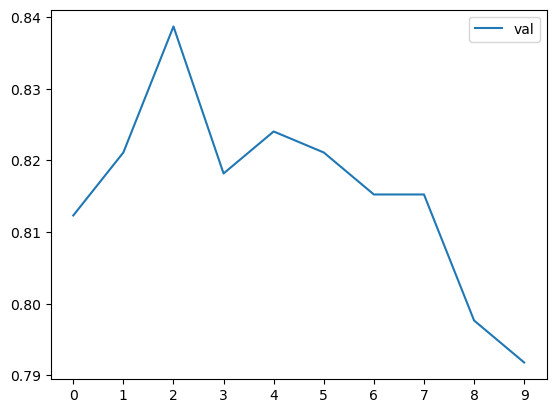

In [32]:
#plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.xticks(np.arange(10))
plt.legend()

### Adjusting the learning rate
* What's the learning rate
* Trying different values

In [33]:
def make_model(learning_rate):
    base_model = Xception(
    weights='imagenet',
    input_shape=(150, 150, 3),
    include_top=False
    )
    
    base_model.trainable = False 
    
    #########################################
    
    inputs = keras.Input(shape=(150, 150, 3))
    base = base_model(inputs, training=False)
    vector = keras.layers.GlobalAveragePooling2D()(base)
    outputs = keras.layers.Dense(10)(vector)
    model = keras.Model(inputs, outputs) 

    #########################################
        
    optimizer = keras.optimizers.Adam(learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)
    model.compile(
        optimizer=optimizer, 
        loss=loss, 
        metrics=['accuracy']
    )
    
    return model


In [34]:
scores = {}

for lr in [0.0001, 0.001, 0.01, 0.1]:
    print(lr)
    model = make_model(learning_rate=lr)
    history = model.fit(train_ds, epochs=10, validation_data=val_ds)
    scores[lr] = history.history
    
    print()
    print()

0.0001
Epoch 1/10
96/96 [==============================] - 15s 133ms/step - loss: 1.9570 - accuracy: 0.3429 - val_loss: 1.6488 - val_accuracy: 0.4780
Epoch 2/10
96/96 [==============================] - 12s 123ms/step - loss: 1.4032 - accuracy: 0.5541 - val_loss: 1.2896 - val_accuracy: 0.5982
Epoch 3/10
96/96 [==============================] - 12s 124ms/step - loss: 1.1530 - accuracy: 0.6382 - val_loss: 1.0998 - val_accuracy: 0.6657
Epoch 4/10
96/96 [==============================] - 12s 125ms/step - loss: 1.0097 - accuracy: 0.6851 - val_loss: 0.9825 - val_accuracy: 0.7009
Epoch 5/10
96/96 [==============================] - 12s 124ms/step - loss: 0.9149 - accuracy: 0.7080 - val_loss: 0.8998 - val_accuracy: 0.7243
Epoch 6/10
96/96 [==============================] - 12s 123ms/step - loss: 0.8478 - accuracy: 0.7259 - val_loss: 0.8450 - val_accuracy: 0.7449
Epoch 7/10
96/96 [==============================] - 12s 123ms/step - loss: 0.7941 - accuracy: 0.7464 - val_loss: 0.8054 - val_accuracy:

In [35]:
preds = model.predict(X)

1/1 [==============================] - 1s 996ms/step


In [36]:
del scores[0.1]
del scores[0.0001]


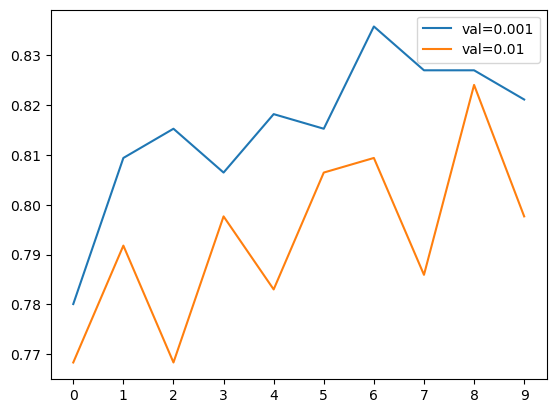

In [37]:
for lr, hist in scores.items():
    
    #plt.plot(hist['accuracy'], label='train=%s' % lr)
    plt.plot(hist['val_accuracy'], label=('val=%s' % lr))
    
plt.xticks(np.arange(10))
plt.legend()

In [38]:
#best learning_rate is 0.001

### Checkpointing
* saving the best model only
* Training a model with callbacks


In [39]:
model.save_weights('model_v1.h5', save_format='h5')

In [40]:
checkpoint = keras.callbacks.ModelCheckpoint(
    "xception_v1_{epoch:02d}_{val_accuracy:.3f}.h5",
    save_best_only=True,
    monitor="val_accuracy",   
)




In [41]:
learning_rate = 0.001

model = make_model(learning_rate=learning_rate)

model.fit(
    train_ds, 
    epochs=10, 
    validation_data=val_ds, 
    callbacks=[checkpoint]
)

Epoch 1/10
96/96 [==============================] - 15s 133ms/step - loss: 1.0744 - accuracy: 0.6353 - val_loss: 0.7311 - val_accuracy: 0.7507
Epoch 2/10
96/96 [==============================] - 12s 125ms/step - loss: 0.6303 - accuracy: 0.7842 - val_loss: 0.6246 - val_accuracy: 0.8006
Epoch 3/10
96/96 [==============================] - 12s 126ms/step - loss: 0.5024 - accuracy: 0.8308 - val_loss: 0.5880 - val_accuracy: 0.8270
Epoch 4/10
96/96 [==============================] - 12s 122ms/step - loss: 0.4251 - accuracy: 0.8644 - val_loss: 0.5581 - val_accuracy: 0.8182
Epoch 5/10
96/96 [==============================] - 12s 124ms/step - loss: 0.3732 - accuracy: 0.8866 - val_loss: 0.5423 - val_accuracy: 0.8211
Epoch 6/10
96/96 [==============================] - 12s 126ms/step - loss: 0.3270 - accuracy: 0.9091 - val_loss: 0.5401 - val_accuracy: 0.8299
Epoch 7/10
96/96 [==============================] - 12s 125ms/step - loss: 0.2858 - accuracy: 0.9241 - val_loss: 0.5299 - val_accuracy: 0.8358

### 8.8 Adding more layers


In [42]:
def make_model(learning_rate=0.01, size_inner=100):
    base_model = Xception(
    weights='imagenet',
    input_shape=(150, 150, 3),
    include_top=False
    )
    base_model.trainable = False 
    
    #########################################
    
    inputs = keras.Input(shape=(150, 150, 3))
    base = base_model(inputs, training=False)
    vector = keras.layers.GlobalAveragePooling2D()(base)
    inner = keras.layers.Dense(100, activation='relu')(vector)
    outputs = keras.layers.Dense(10)(inner)
    model = keras.Model(inputs, outputs) 

    #########################################
        
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)
    model.compile(
        optimizer=optimizer, 
        loss=loss, 
        metrics=['accuracy']
    )
    return model


In [43]:
learning_rate = 0.001

scores = {}  

for size in [10, 100, 1000]:
    print(size)
    
    model = make_model(learning_rate=learning_rate, size_inner=size)
    history = model.fit(train_ds, epochs=10, validation_data=val_ds)
    scores[size] = history.history
    
    print()
    print()

10
Epoch 1/10
96/96 [==============================] - 15s 131ms/step - loss: 0.9554 - accuracy: 0.6685 - val_loss: 0.6683 - val_accuracy: 0.7859
Epoch 2/10
96/96 [==============================] - 12s 123ms/step - loss: 0.5118 - accuracy: 0.8181 - val_loss: 0.5981 - val_accuracy: 0.8006
Epoch 3/10
96/96 [==============================] - 12s 124ms/step - loss: 0.3694 - accuracy: 0.8787 - val_loss: 0.5473 - val_accuracy: 0.8123
Epoch 4/10
96/96 [==============================] - 12s 124ms/step - loss: 0.2573 - accuracy: 0.9231 - val_loss: 0.5207 - val_accuracy: 0.8270
Epoch 5/10
96/96 [==============================] - 12s 123ms/step - loss: 0.1797 - accuracy: 0.9560 - val_loss: 0.5879 - val_accuracy: 0.8152
Epoch 6/10
96/96 [==============================] - 12s 125ms/step - loss: 0.1270 - accuracy: 0.9697 - val_loss: 0.5445 - val_accuracy: 0.8328
Epoch 7/10
96/96 [==============================] - 12s 123ms/step - loss: 0.0900 - accuracy: 0.9873 - val_loss: 0.5877 - val_accuracy: 0.8

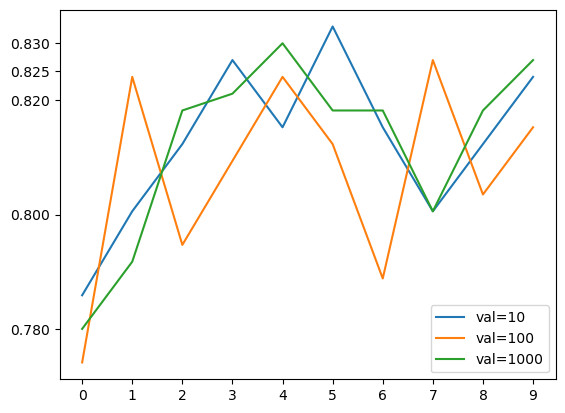

In [44]:
for size, hist in scores.items():
    
    #plt.plot(hist['accuracy'], label='train=%s' % lr)
    plt.plot(hist['val_accuracy'], label=('val=%s' % size))
    
plt.xticks(np.arange(10))
plt.yticks([0.78, 0.80, 0.82, 0.825, 0.83])
plt.legend()

### Regularization and Dropout
* Regularizing by freezing a part of the network
* Adding dropout to our model
* Experimenting with different values

In [45]:
def make_model(learning_rate=0.01, size_inner=100, droprate=0.5):
    base_model = Xception(
    weights='imagenet',
    input_shape=(150, 150, 3),
    include_top=False
    )
    base_model.trainable = False 
    
    #########################################
    
    inputs = keras.Input(shape=(150, 150, 3))
    base = base_model(inputs, training=False)
    vector = keras.layers.GlobalAveragePooling2D()(base)
    
    inner = keras.layers.Dense(100, activation='relu')(vector)
    drop = keras.layers.Dense(droprate)(inner)
    outputs = keras.layers.Dense(10)(drop)
    
    model = keras.Model(inputs, outputs) 

    #########################################
        
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)
    
    model.compile(
        optimizer=optimizer, 
        loss=loss, 
        metrics=["accuracy"]
    )
    
    return model
 

In [46]:
learning_rate = 0.001
size = 100

scores = {}  

for droprate in [0.0, 0.2, 0.5, 0.8]:
    print(droprate)
    
    model = make_model(
        learning_rate=learning_rate, 
        size_inner=size,
        droprate=droprate
    )
    
    history = model.fit(
        train_ds, epochs=30, 
        validation_data=val_ds)
    scores[droprate] = history.history
    
    print()
    print()

0.0
Epoch 1/30
96/96 [==============================] - 15s 132ms/step - loss: 2.2847 - accuracy: 0.2536 - val_loss: 2.2725 - val_accuracy: 0.2375
Epoch 2/30
96/96 [==============================] - 12s 123ms/step - loss: 2.2531 - accuracy: 0.2591 - val_loss: 2.2478 - val_accuracy: 0.2375
Epoch 3/30
96/96 [==============================] - 12s 122ms/step - loss: 2.2265 - accuracy: 0.2591 - val_loss: 2.2276 - val_accuracy: 0.2375
Epoch 4/30
96/96 [==============================] - 12s 124ms/step - loss: 2.2044 - accuracy: 0.2591 - val_loss: 2.2111 - val_accuracy: 0.2375
Epoch 5/30
96/96 [==============================] - 12s 123ms/step - loss: 2.1862 - accuracy: 0.2591 - val_loss: 2.1983 - val_accuracy: 0.2375
Epoch 6/30
96/96 [==============================] - 12s 123ms/step - loss: 2.1717 - accuracy: 0.2591 - val_loss: 2.1880 - val_accuracy: 0.2375
Epoch 7/30
96/96 [==============================] - 12s 123ms/step - loss: 2.1597 - accuracy: 0.2591 - val_loss: 2.1801 - val_accuracy: 0.

Epoch 28/30
96/96 [==============================] - 12s 123ms/step - loss: 2.1175 - accuracy: 0.2591 - val_loss: 2.1595 - val_accuracy: 0.2375
Epoch 29/30
96/96 [==============================] - 12s 125ms/step - loss: 2.1174 - accuracy: 0.2591 - val_loss: 2.1595 - val_accuracy: 0.2375
Epoch 30/30
96/96 [==============================] - 12s 122ms/step - loss: 2.1174 - accuracy: 0.2591 - val_loss: 2.1596 - val_accuracy: 0.2375


0.5
Epoch 1/30
96/96 [==============================] - 15s 131ms/step - loss: 2.2847 - accuracy: 0.2484 - val_loss: 2.2723 - val_accuracy: 0.2375
Epoch 2/30
96/96 [==============================] - 12s 126ms/step - loss: 2.2526 - accuracy: 0.2591 - val_loss: 2.2475 - val_accuracy: 0.2375
Epoch 3/30
96/96 [==============================] - 12s 123ms/step - loss: 2.2260 - accuracy: 0.2591 - val_loss: 2.2273 - val_accuracy: 0.2375
Epoch 4/30
96/96 [==============================] - 12s 122ms/step - loss: 2.2041 - accuracy: 0.2591 - val_loss: 2.2112 - val_accurac

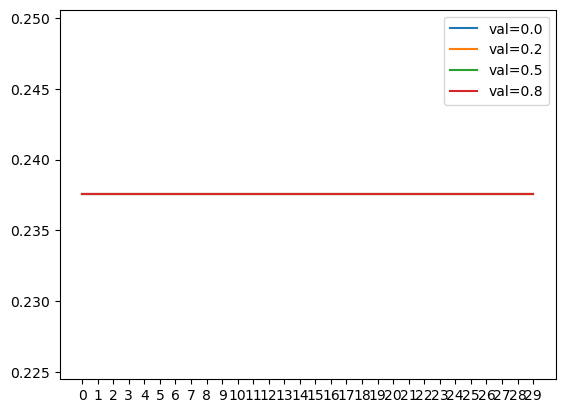

In [59]:
for droprate, hist in scores.items():
    
    #plt.plot(hist['accuracy'], label='train=%s' % lr)
    plt.plot(hist['val_accuracy'], label=('val=%s' % droprate))
    
plt.xticks(np.arange(30))
plt.legend()

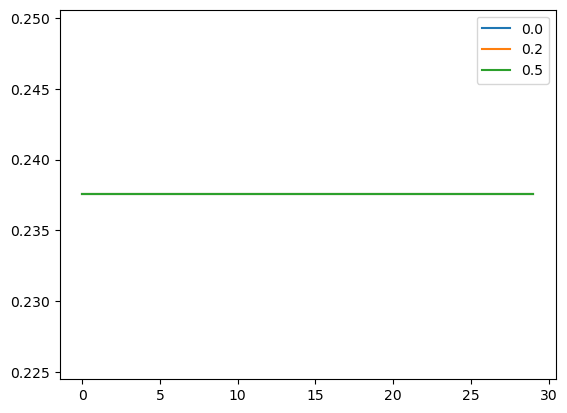

In [48]:
hist = scores[0.0]
    #plt.plot(hist['accuracy'], label='train=%s' % lr)
plt.plot(hist['val_accuracy'], label=0.0)
    
hist = scores[0.2]
    #plt.plot(hist['accuracy'], label='train=%s' % lr)
plt.plot(hist['val_accuracy'], label=0.2)

hist = scores[0.5]
    #plt.plot(hist['accuracy'], label='train=%s' % lr)
plt.plot(hist['val_accuracy'], label=0.5)

plt.legend()

### Data augmentation

In [49]:
train_gen = ImageDataGenerator(
    shear_range=10.0,
    zoom_range=0.1,
    horizontal_flip=True,
    preprocessing_function=preprocess_input
)

train_ds = train_gen.flow_from_directory(
    "clothing-dataset-small/train",
    target_size=(150, 150),
    batch_size=32
)

val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_ds = train_gen.flow_from_directory(
    "clothing-dataset-small/validation",
    target_size=(150, 150),
    batch_size=32
)

Found 3068 images belonging to 10 classes.
Found 341 images belonging to 10 classes.


In [50]:
learning_rate = 0.001
size = 100
droprate = 0.2

model = make_model(
        learning_rate=learning_rate, 
        size_inner=size,
        droprate=droprate
)
    
history = model.fit(
        train_ds, epochs=50, 
        validation_data=val_ds)  

Epoch 1/50
96/96 [==============================] - 29s 281ms/step - loss: 2.2855 - accuracy: 0.2533 - val_loss: 2.2731 - val_accuracy: 0.2375
Epoch 2/50
96/96 [==============================] - 27s 278ms/step - loss: 2.2536 - accuracy: 0.2591 - val_loss: 2.2483 - val_accuracy: 0.2375
Epoch 3/50
96/96 [==============================] - 26s 275ms/step - loss: 2.2268 - accuracy: 0.2591 - val_loss: 2.2277 - val_accuracy: 0.2375
Epoch 4/50
96/96 [==============================] - 26s 274ms/step - loss: 2.2047 - accuracy: 0.2591 - val_loss: 2.2115 - val_accuracy: 0.2375
Epoch 5/50
96/96 [==============================] - 26s 272ms/step - loss: 2.1866 - accuracy: 0.2591 - val_loss: 2.1984 - val_accuracy: 0.2375
Epoch 6/50
96/96 [==============================] - 26s 271ms/step - loss: 2.1718 - accuracy: 0.2591 - val_loss: 2.1884 - val_accuracy: 0.2375
Epoch 7/50
96/96 [==============================] - 26s 269ms/step - loss: 2.1598 - accuracy: 0.2591 - val_loss: 2.1803 - val_accuracy: 0.2375

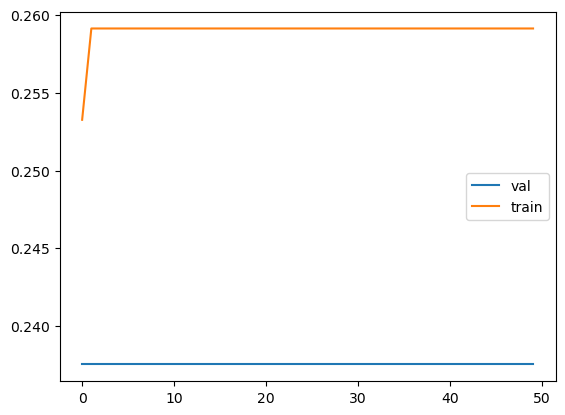

In [51]:
hist = history.history
plt.plot(hist['val_accuracy'], label='val')
plt.plot(hist['accuracy'], label='train')
    

plt.legend()

 ### Training a Larger Model
 * Train a 299 x 299

In [52]:
def make_model(input_size=150, learning_rate=0.01, size_inner=100, droprate=0.5):
    base_model = Xception(
    weights='imagenet',
    input_shape=(input_size, input_size, 3),
    include_top=False
    )
    
    base_model.trainable = False 
    
    #########################################
    
    inputs = keras.Input(shape=(input_size, input_size, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
    drop = keras.layers.Dense(droprate)(inner)
    outputs = keras.layers.Dense(10)(drop)
    model = keras.Model(inputs, outputs) 

    #########################################
        
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)
    
    model.compile(
        optimizer=optimizer, 
        loss=loss, 
        metrics=['accuracy']
    )
    
    return model
 

In [53]:
input_size=299

In [54]:
train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    #shear_range=10.0,
    #zoom_range=0.1,
    #horizontal_flip=True 
     
)

train_ds = train_gen.flow_from_directory(
    "clothing-dataset-small/train",
    target_size=(input_size, input_size),
    batch_size=32
)

val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_ds = train_gen.flow_from_directory(
    "clothing-dataset-small/validation",
    target_size=(input_size, input_size),
    batch_size=32,
    shuffle=False
)

Found 3068 images belonging to 10 classes.
Found 341 images belonging to 10 classes.


In [55]:
checkpoint = keras.callbacks.ModelCheckpoint(
    "xception_v4_1_{epoch:02d}_{val_accuracy:.3f}.h5",
    monitor="val_accuracy",
    save_best_only=True,
    mode='max'
)

In [56]:
learning_rate = 0.001
size = 100
droprate = 0.2
input_size = 299

model = make_model(
        input_size=299,
        learning_rate=learning_rate, 
        size_inner=size,
        droprate=droprate
)
    
history = model.fit(
        train_ds, epochs=50, 
        validation_data=val_ds, callbacks=[checkpoint])  

Epoch 1/50
96/96 [==============================] - 32s 299ms/step - loss: 2.2855 - accuracy: 0.2572 - val_loss: 2.2730 - val_accuracy: 0.2375
Epoch 2/50
96/96 [==============================] - 26s 270ms/step - loss: 2.2535 - accuracy: 0.2591 - val_loss: 2.2484 - val_accuracy: 0.2375
Epoch 3/50
96/96 [==============================] - 26s 270ms/step - loss: 2.2266 - accuracy: 0.2591 - val_loss: 2.2276 - val_accuracy: 0.2375
Epoch 4/50
96/96 [==============================] - 26s 273ms/step - loss: 2.2043 - accuracy: 0.2591 - val_loss: 2.2113 - val_accuracy: 0.2375
Epoch 5/50
96/96 [==============================] - 27s 275ms/step - loss: 2.1861 - accuracy: 0.2591 - val_loss: 2.1985 - val_accuracy: 0.2375
Epoch 6/50
96/96 [==============================] - 27s 277ms/step - loss: 2.1715 - accuracy: 0.2591 - val_loss: 2.1880 - val_accuracy: 0.2375
Epoch 7/50
96/96 [==============================] - 27s 280ms/step - loss: 2.1596 - accuracy: 0.2591 - val_loss: 2.1802 - val_accuracy: 0.2375